findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.



|Phi+> = (|00> + |11>)/sqrt(2)
  S parameter: 2.8376
  [VIOLATED] Bell inequality violated (101.1% of Tsirelson bound)

|Phi-> = (|00> - |11>)/sqrt(2)
  S parameter: 2.8378
  [VIOLATED] Bell inequality violated (101.1% of Tsirelson bound)

|Psi+> = (|01> + |10>)/sqrt(2)
  S parameter: 2.7918
  [VIOLATED] Bell inequality violated (95.6% of Tsirelson bound)

|Psi-> = (|01> - |10>)/sqrt(2)
  S parameter: 2.8062
  [VIOLATED] Bell inequality violated (97.3% of Tsirelson bound)
Saved visualization to: bell_test_results.png


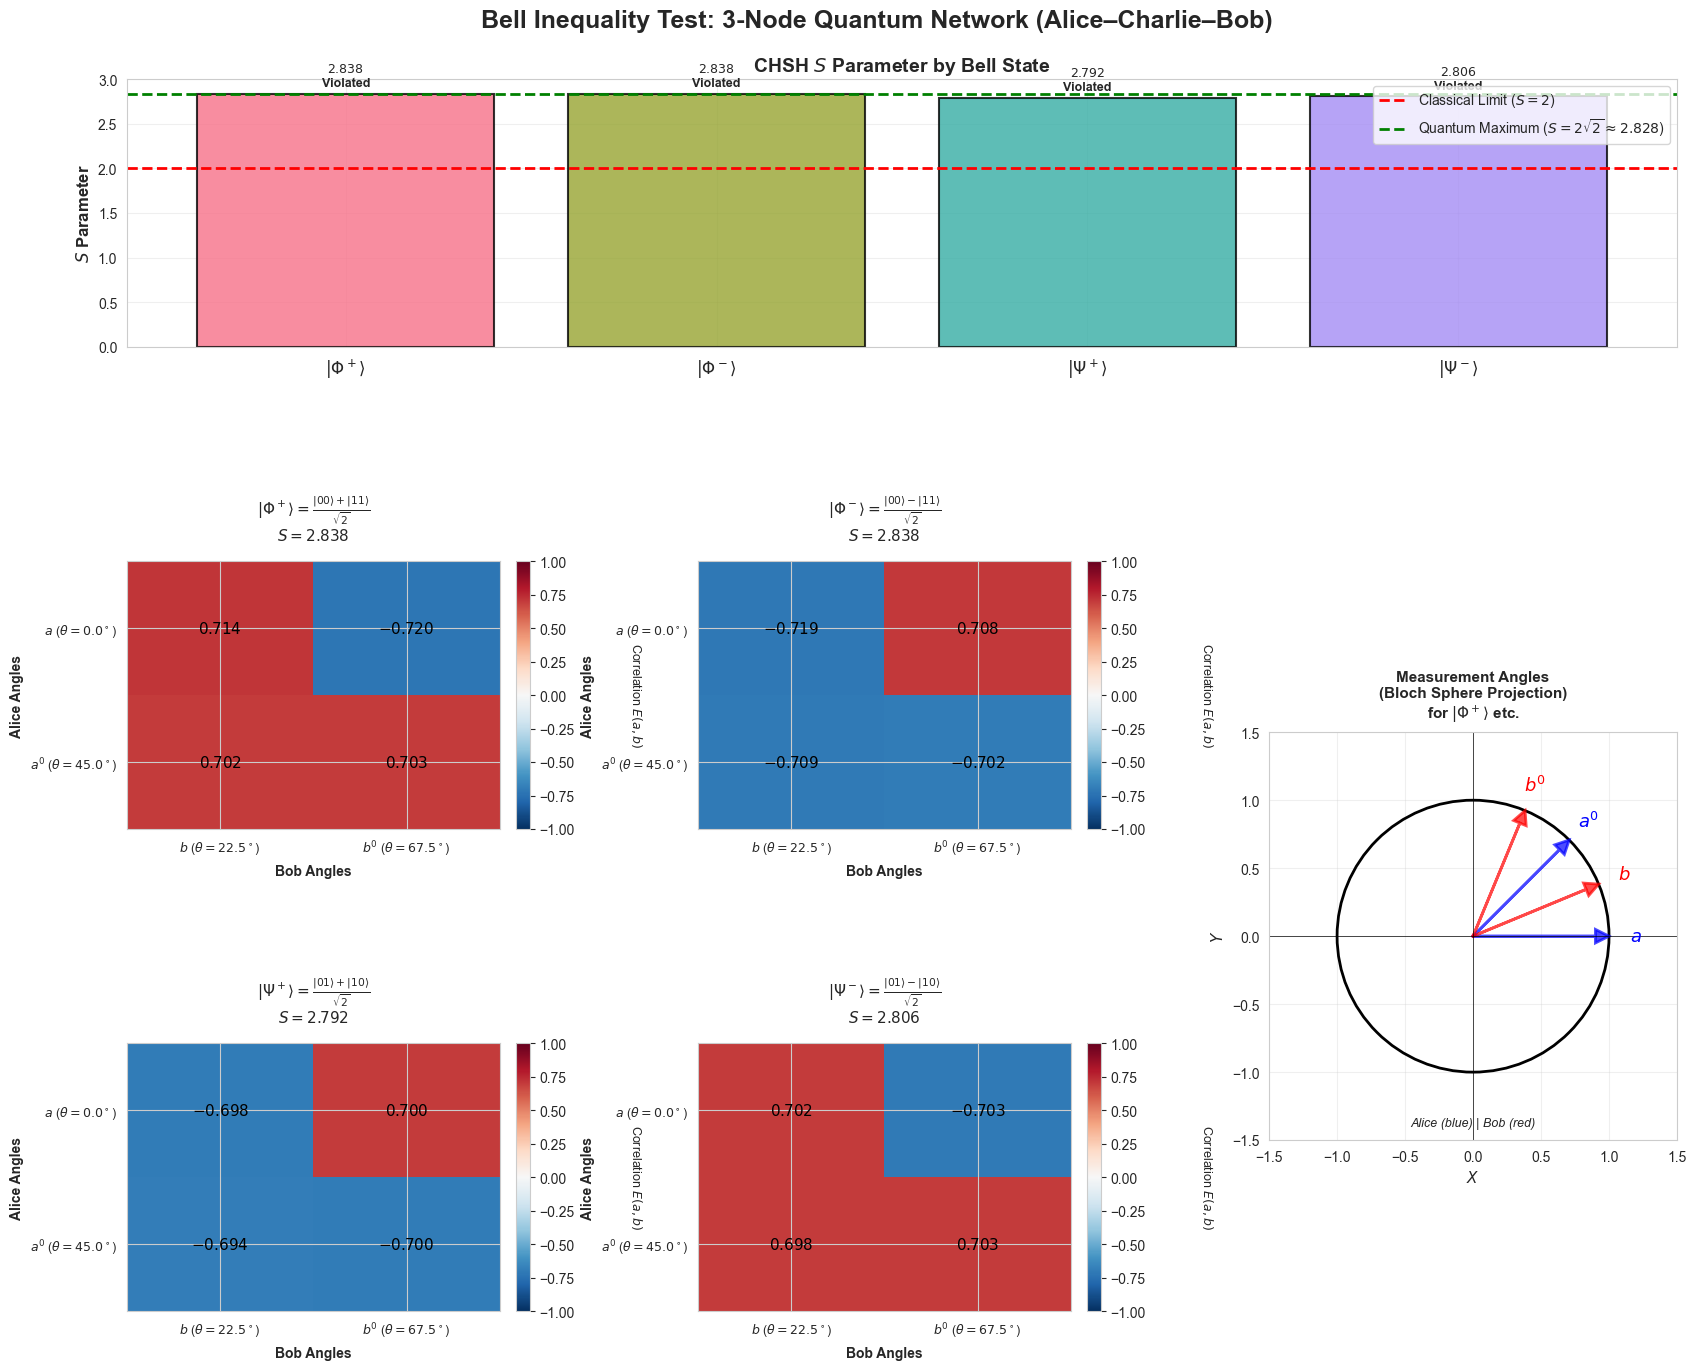


Simulation complete!


In [1]:
import sys
import subprocess

try:
    import numpy as np
    numpy_version = np.__version__
    if numpy_version.startswith('2.'):
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2", "--force-reinstall"])
        sys.exit(0)
except Exception as e:
    print(f"Error checking NumPy version: {e}")
    import numpy as np 

from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel
from sequence.components.memory import Memory 

from math import sqrt, cos, sin, pi
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns

LIGHT_SPEED = 2e8
DISTANCE = 1000  



class BellState:
    PHI_PLUS = "phi_plus"
    PHI_MINUS = "phi_minus"
    PSI_PLUS = "psi_plus"
    PSI_MINUS = "psi_minus"

    @staticmethod
    def get_all():
        return [
            BellState.PHI_PLUS,
            BellState.PHI_MINUS,
            BellState.PSI_PLUS,
            BellState.PSI_MINUS,
        ]

    @staticmethod
    def get_description(state):
        descriptions = {
            BellState.PHI_PLUS: r"$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$",
            BellState.PHI_MINUS: r"$|\Phi^-\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}}$",
            BellState.PSI_PLUS: r"$|\Psi^+\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$",
            BellState.PSI_MINUS: r"$|\Psi^-\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}}$",
        }
        return descriptions.get(state, "Unknown")



class OptimizedBellTest:
    def __init__(self):
        self.timeline = Timeline(1e12)
        self.nodes = {}
        self.results_cache = {}

    def setup_network(self):

        alice = QuantumRouter("Alice", self.timeline)
        charlie = QuantumRouter("Charlie", self.timeline)
        bob = QuantumRouter("Bob", self.timeline)

        self.nodes = {"alice": alice, "charlie": charlie, "bob": bob}

        qc_ca = QuantumChannel(
            "qc_ca",
            self.timeline,
            distance=DISTANCE,
            attenuation=0.0002,
        )
        qc_cb = QuantumChannel(
            "qc_cb",
            self.timeline,
            distance=DISTANCE,
            attenuation=0.0002,
        )

        cc_ac = ClassicalChannel("cc_ac", self.timeline, distance=DISTANCE)
        cc_bc = ClassicalChannel("cc_bc", self.timeline, distance=DISTANCE)
        cc_ab = ClassicalChannel("cc_ab", self.timeline, distance=2 * DISTANCE)

        qc_ca.set_ends(charlie, alice)
        qc_cb.set_ends(charlie, bob)
        cc_ac.set_ends(alice, charlie)
        cc_bc.set_ends(bob, charlie)
        cc_ab.set_ends(alice, bob)



  
    def generate_entangled_pair(self, bell_state):

        random_val = np.random.random()

        if bell_state == BellState.PHI_PLUS:
            if random_val < 0.5:
                return 0, 0, 1.0
            return 1, 1, 1.0

        elif bell_state == BellState.PHI_MINUS:
            if random_val < 0.5:
                return 0, 0, -1.0
            return 1, 1, -1.0

        elif bell_state == BellState.PSI_PLUS:
            if random_val < 0.5:
                return 0, 1, 1.0
            return 1, 0, 1.0

        elif bell_state == BellState.PSI_MINUS:
            if random_val < 0.5:
                return 0, 1, -1.0
            return 1, 0, -1.0

        return 0, 0, 1.0

    def measure_entangled_pair(self, alice_bit, bob_bit, phase, alice_angle, bob_angle):
 
        angle_diff = bob_angle - alice_angle

        if alice_bit == bob_bit:
            expected_correlation = phase * cos(2 * angle_diff)
        else:
            expected_correlation = -phase * cos(2 * angle_diff)

        prob_alice_0 = 0.5
        alice_result = 0 if np.random.random() < prob_alice_0 else 1

        if alice_result == 0:
            prob_bob_0 = 0.5 * (1 + expected_correlation)
        else:
            prob_bob_0 = 0.5 * (1 - expected_correlation)

        bob_result = 0 if np.random.random() < prob_bob_0 else 1

        return alice_result, bob_result

    def run_bell_test(self, bell_state, num_trials=10000):


        alice_angles = np.array([0, pi / 4])
        bob_angles = np.array([pi / 8, 3 * pi / 8])

        correlations = np.zeros((2, 2))

        angle_pairs = [(i, j) for i in range(2) for j in range(2)]

        for i, j in angle_pairs:
            a_angle = alice_angles[i]
            b_angle = bob_angles[j]

            correlation_sum = 0

            for _ in range(num_trials):
                alice_bit, bob_bit, phase = self.generate_entangled_pair(bell_state)

                alice_result, bob_result = self.measure_entangled_pair(
                    alice_bit, bob_bit, phase, a_angle, b_angle
                )

                correlation = 1 if alice_result == bob_result else -1
                correlation_sum += correlation

            correlations[i, j] = correlation_sum / num_trials

        return correlations, alice_angles, bob_angles

    @staticmethod
    def calculate_chsh(correlations):
        return abs(
            correlations[0, 0]
            - correlations[0, 1]
            + correlations[1, 0]
            + correlations[1, 1]
        )

    def run_all_bell_states(self, num_trials=10000):
        results = {}

        for bell_state in BellState.get_all():
            correlations, alice_angles, bob_angles = self.run_bell_test(
                bell_state, num_trials
            )
            S = self.calculate_chsh(correlations)
            results[bell_state] = {
                "correlations": correlations,
                "S": S,
                "description": BellState.get_description(bell_state),
                "alice_angles": alice_angles,
                "bob_angles": bob_angles,
            }

        return results


class BellTestVisualizer:
    def __init__(self):
        sns.set_style("whitegrid")
        self.colors = sns.color_palette("husl", 4)

    def visualize_results(self, results):
        fig = plt.figure(figsize=(20, 14))
        gs = fig.add_gridspec(3, 3, hspace=0.8, wspace=0.4, top=0.93, bottom=0.05)

        ax_s = fig.add_subplot(gs[0, :])
        self.plot_s_parameters(ax_s, results)

        for idx, (bell_state, data) in enumerate(results.items()):
            row = 1 + idx // 2
            col = idx % 2
            ax = fig.add_subplot(gs[row, col])
            self.plot_correlation_heatmap(ax, data, bell_state)

        ax_bloch = fig.add_subplot(gs[1:, 2])
        self.plot_measurement_geometry(ax_bloch, results)

        fig.suptitle(
            "Bell Inequality Test: 3-Node Quantum Network (Alice–Charlie–Bob)",
            fontsize=18,
            fontweight="bold",
            y=0.98,
        )

        return fig

    def plot_s_parameters(self, ax, results):
        states = list(results.keys())
        s_values = [results[state]["S"] for state in states]
        colors = self.colors

        bars = ax.bar(
            range(len(states)),
            s_values,
            color=colors,
            alpha=0.8,
            edgecolor="black",
            linewidth=1.5,
        )

        ax.axhline(
            y=2, color="red", linestyle="--", linewidth=2, label=r"Classical Limit ($S=2$)"
        )
        ax.axhline(
            y=2 * sqrt(2),
            color="green",
            linestyle="--",
            linewidth=2,
            label=r"Quantum Maximum ($S=2\sqrt{2} \approx 2.828$)",
        )

        ax.set_ylabel("$S$ Parameter", fontsize=12, fontweight="bold")
        ax.set_title("CHSH $S$ Parameter by Bell State", fontsize=14, fontweight="bold")
        ax.set_xticks(range(len(states)))

        labels = [
            r"$|\Phi^+\rangle$",
            r"$|\Phi^-\rangle$",
            r"$|\Psi^+\rangle$",
            r"$|\Psi^-\rangle$",
        ]
        ax.set_xticklabels(labels, fontsize=12)

        ax.legend(loc="upper right", fontsize=10)
        ax.set_ylim([0, 3])
        ax.grid(True, alpha=0.3)

        for bar, s_val in zip(bars, s_values):
            height = bar.get_height()
            violation = "Violated" if s_val > 2 else "Not Violated"
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.05,
                f"${s_val:.3f}$\n{violation}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

    def plot_correlation_heatmap(self, ax, data, bell_state):
        correlations = data["correlations"]
        S = data["S"]
        alice_angles = data["alice_angles"]
        bob_angles = data["bob_angles"]

        im = ax.imshow(correlations, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")

        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])

        bob_labels = [
            rf"$b$ ($\theta = {np.degrees(bob_angles[0]):.1f}^\circ$)",
            rf"$b'$ ($\theta = {np.degrees(bob_angles[1]):.1f}^\circ$)",
        ]
        alice_labels = [
            rf"$a$ ($\theta = {np.degrees(alice_angles[0]):.1f}^\circ$)",
            rf"$a'$ ($\theta = {np.degrees(alice_angles[1]):.1f}^\circ$)",
        ]

        ax.set_xticklabels(bob_labels, fontsize=9)
        ax.set_yticklabels(alice_labels, fontsize=9)

        ax.set_xlabel("Bob Angles", fontsize=10, fontweight="bold")
        ax.set_ylabel("Alice Angles", fontsize=10, fontweight="bold")

        description = BellState.get_description(bell_state)
        title_text = f"{description}\n$S = {S:.3f}$"
        ax.set_title(title_text, fontsize=11, pad=15)

        for i in range(2):
            for j in range(2):
                ax.text(
                    j,
                    i,
                    f"${correlations[i, j]:.3f}$",
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=11,
                    fontweight="bold",
                )

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(r"Correlation $E(a,b)$", rotation=270, labelpad=50, fontsize=9)

    def plot_measurement_geometry(self, ax, results):
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect("equal")

        circle = Circle((0, 0), 1, fill=False, edgecolor="black", linewidth=2)
        ax.add_patch(circle)

        sample_state = list(results.keys())[0]
        alice_angles = results[sample_state]["alice_angles"]
        bob_angles_plus = results[sample_state]["bob_angles"]

        for i, angle in enumerate(alice_angles):
            x = cos(angle)
            y = sin(angle)
            ax.arrow(
                0,
                0,
                x * 0.9,
                y * 0.9,
                head_width=0.1,
                head_length=0.1,
                fc="blue",
                ec="blue",
                linewidth=2,
                alpha=0.7,
            )
            label = r"$a$" if i == 0 else r"$a'$"
            ax.text(
                x * 1.2,
                y * 1.2,
                label,
                fontsize=13,
                fontweight="bold",
                color="blue",
                ha="center",
                va="center",
            )

        for i, angle in enumerate(bob_angles_plus):
            x = cos(angle)
            y = sin(angle)
            ax.arrow(
                0,
                0,
                x * 0.9,
                y * 0.9,
                head_width=0.1,
                head_length=0.1,
                fc="red",
                ec="red",
                linewidth=2,
                alpha=0.7,
            )
            label = r"$b$" if i == 0 else r"$b'$"
            ax.text(
                x * 1.2,
                y * 1.2,
                label,
                fontsize=13,
                fontweight="bold",
                color="red",
                ha="center",
                va="center",
            )

        title_text = (
            "Measurement Angles\n"
            "(Bloch Sphere Projection)\n"
            r"for $|\Phi^+\rangle$ etc."
        )
        ax.set_title(title_text, fontsize=11, fontweight="bold", pad=10)
        ax.set_xlabel(r"$X$", fontsize=11, fontweight="bold")
        ax.set_ylabel(r"$Y$", fontsize=11, fontweight="bold")
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color="k", linewidth=0.5)
        ax.axvline(x=0, color="k", linewidth=0.5)

        ax.text(
            0,
            -1.4,
            "Alice (blue) | Bob (red)",
            ha="center",
            fontsize=9,
            style="italic",
        )


def main():

    bell_test = OptimizedBellTest()
    bell_test.setup_network()

    num_trials = 10000
    results = bell_test.run_all_bell_states(num_trials=num_trials)


    bell_state_names = {
        BellState.PHI_PLUS: "|Phi+> = (|00> + |11>)/sqrt(2)",
        BellState.PHI_MINUS: "|Phi-> = (|00> - |11>)/sqrt(2)",
        BellState.PSI_PLUS: "|Psi+> = (|01> + |10>)/sqrt(2)",
        BellState.PSI_MINUS: "|Psi-> = (|01> - |10>)/sqrt(2)",
    }

    for bell_state, data in results.items():
        print(f"\n{bell_state_names[bell_state]}")
        print(f"  S parameter: {data['S']:.4f}")
        if data["S"] > 2:
            violation = (data["S"] - 2) / (2 * sqrt(2) - 2) * 100
            print(
                f"  [VIOLATED] Bell inequality violated ({violation:.1f}% of Tsirelson bound)"
            )
        else:
            print("  [NOT VIOLATED] Bell inequality not violated")

    visualizer = BellTestVisualizer()
    fig = visualizer.visualize_results(results)
    plt.savefig("bell_test_results.png", dpi=300, bbox_inches="tight")
    print("Saved visualization to: bell_test_results.png")
    plt.show()

    print("\nSimulation complete!")


if __name__ == "__main__":
    main()